In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head()

,Date,Time (utc),Region,Magnitude,Depth (km),Latitude,Longitude,Mode,Map
0,23/06/2024,04:51:49,"Mindanao, Philippine",4.8,342,8.01 N,125.20 E,A,-
1,23/06/2024,03:58:03,Near Coast of Venezuela,5.9,105,10.80 N,62.65 W,A,-
2,23/06/2024,03:12:08,"Near East Coast of Honshu, japan",5.0,55,37.16 N,141.09 E,A,-
3,22/06/2024,20:46:51,Near Coast of Peru,5.3,64,15.79 S,74.47 W,A,-
4,22/06/2024,18:08:44,Afghanistan-Tajikistan Border Region,3.8,179,36.36 N,71.45 E,M,-


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14726 entries, 0 to 14725
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        14726 non-null  object 
 1   Time (utc)  14726 non-null  object 
 2   Region      14726 non-null  object 
 3   Magnitude   14726 non-null  float64
 4   Depth (km)  14726 non-null  int64  
 5   Latitude    14726 non-null  object 
 6   Longitude   14726 non-null  object 
 7   Mode        14726 non-null  object 
 8   Map         14598 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.0+ MB


In [6]:
df.describe(include='all')

,Date,Time (utc),Region,Magnitude,Depth (km),Latitude,Longitude,Mode,Map
count,14726,14726,14726,14726.000000,14726.000000,14726,14726,14726,14598
unique,2672,13391,3221,NaN,NaN,6517,7664,2,1
top,03/12/2023,02:02:35,"Hindu Kush Region, Afghanistan",NaN,NaN,36.54 N,71.03 E,A,-
freq,51,4,1592,NaN,NaN,70,38,7374,14598
mean,NaN,NaN,NaN,4.465259,94.491783,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,1.048695,116.171875,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.700000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,3.700000,11.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,4.600000,60.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,5.200000,134.000000,NaN,NaN,NaN,NaN


In [7]:
df.shape

(14726, 9)

In [8]:
df.isnull().sum(axis=0)

Date            0
Time (utc)      0
Region          0
Magnitude       0
Depth (km)      0
Latitude        0
Longitude       0
Mode            0
Map           128
dtype: int64

In [9]:
df.replace('', np.nan, inplace=True)
df.dropna(subset=['Date', 'Time (utc)', 'Magnitude', 'Depth (km)', 'Latitude', 'Longitude'], inplace=True)

In [10]:
# Convert Date and Time columns to datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time (utc)'], format='%d/%m/%Y %H:%M:%S')

# Convert Magnitude and Depth columns to numeric types
df['Magnitude'] = pd.to_numeric(df['Magnitude'], errors='coerce')
df['Depth (km)'] = pd.to_numeric(df['Depth (km)'], errors='coerce')

# Convert Latitude and Longitude to floats after removing directional indicators
df['Latitude'] = df['Latitude'].str.extract(r'(\d+\.\d+)')[0].astype(float) * df['Latitude'].str.extract(r'([NS])')[0].map({'N': 1, 'S': -1})
df['Longitude'] = df['Longitude'].str.extract(r'(\d+\.\d+)')[0].astype(float) * df['Longitude'].str.extract(r'([EW])')[0].map({'E': 1, 'W': -1})

In [11]:
# Drop any rows with missing values
df = df.dropna()

In [12]:
df.head()

,Date,Time (utc),Region,Magnitude,Depth (km),Latitude,Longitude,Mode,Map,Datetime
0,23/06/2024,04:51:49,"Mindanao, Philippine",4.8,342,8.01,125.20,A,-,2024-06-23 04:51:49
1,23/06/2024,03:58:03,Near Coast of Venezuela,5.9,105,10.80,-62.65,A,-,2024-06-23 03:58:03
2,23/06/2024,03:12:08,"Near East Coast of Honshu, japan",5.0,55,37.16,141.09,A,-,2024-06-23 03:12:08
3,22/06/2024,20:46:51,Near Coast of Peru,5.3,64,-15.79,-74.47,A,-,2024-06-22 20:46:51
4,22/06/2024,18:08:44,Afghanistan-Tajikistan Border Region,3.8,179,36.36,71.45,M,-,2024-06-22 18:08:44


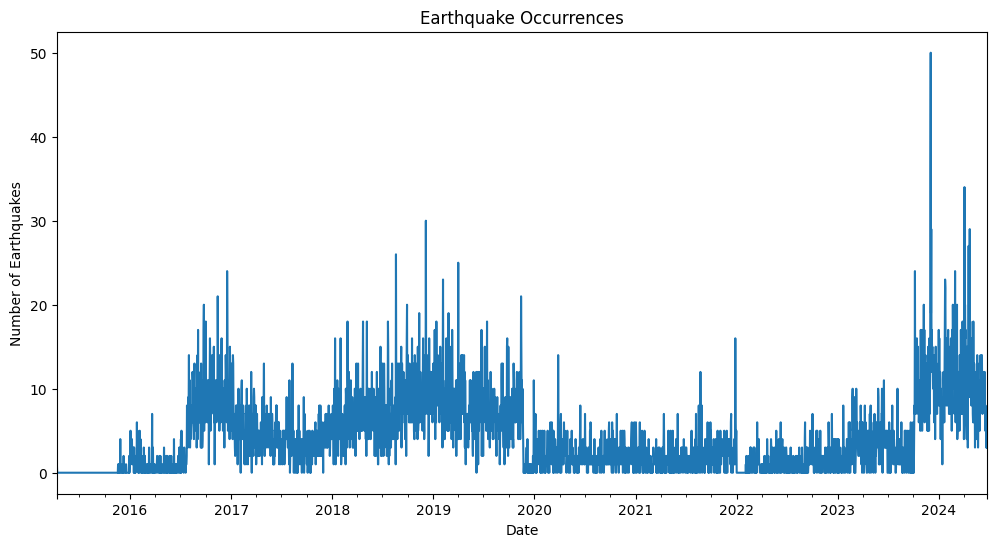

In [13]:
plt.figure(figsize=(12, 6))
df.set_index('Datetime').resample('D').size().plot()
plt.title('Earthquake Occurrences')
plt.xlabel('Date')
plt.ylabel('Number of Earthquakes')
plt.show()

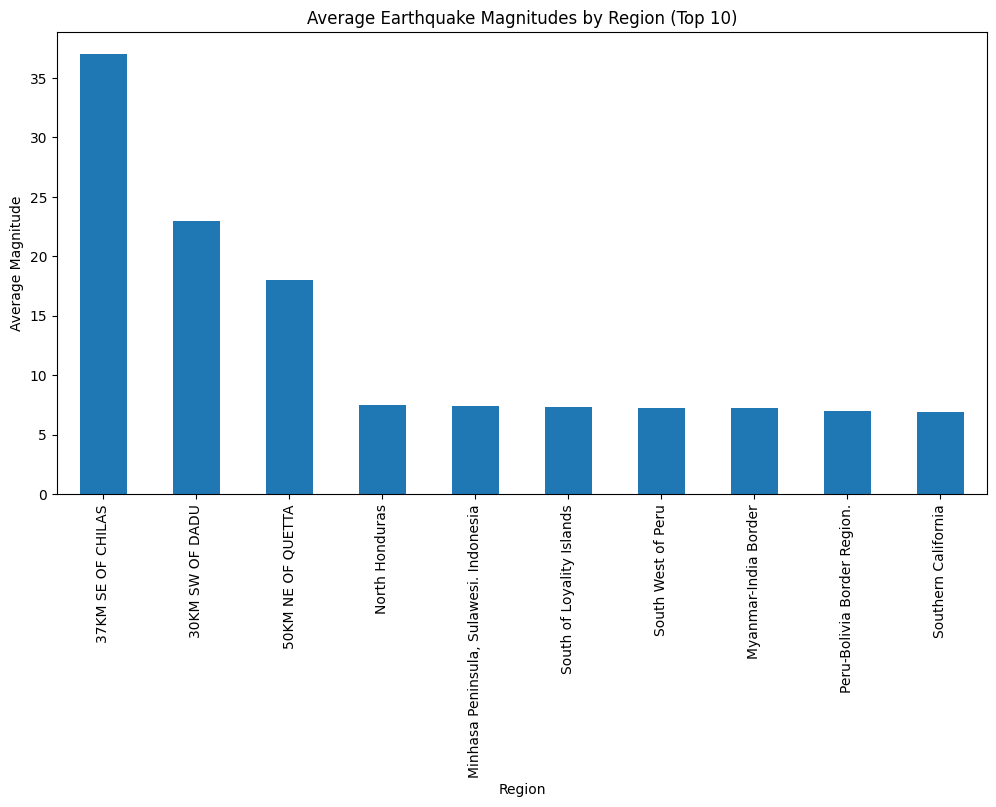

In [14]:
plt.figure(figsize=(12, 6))
region_magnitudes = df.groupby('Region')['Magnitude'].mean().sort_values(ascending=False).head(10)
region_magnitudes.plot(kind='bar')
plt.title('Average Earthquake Magnitudes by Region (Top 10)')
plt.xlabel('Region')
plt.ylabel('Average Magnitude')
plt.show()

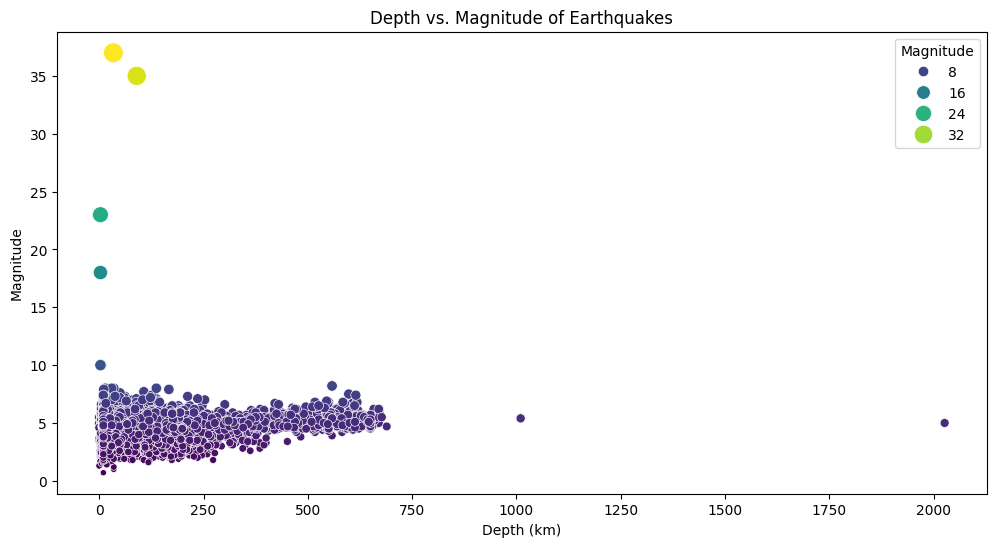

In [15]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Depth (km)', y='Magnitude', hue='Magnitude', palette='viridis', size='Magnitude', sizes=(20, 200))
plt.title('Depth vs. Magnitude of Earthquakes')
plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.legend(title='Magnitude')
plt.show()

In [20]:
X = df[['Date', 'Time (utc)', 'Region', 'Depth (km)', 'Latitude', 'Longitude']]
y = df['Magnitude']

In [21]:
# Preprocessing for numerical features: Depth, Latitude, Longitude
numeric_features = ['Depth (km)', 'Latitude', 'Longitude']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical features: Date, Time, Region
categorical_features = ['Date', 'Time (utc)', 'Region']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create a pipeline that combines preprocessing and model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

In [22]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [23]:
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.3144218179295922
R^2 Score: 0.6481786910595104
